In [1]:
import sys
import pandas as pd
import numpy as np
print(sys.version)


3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 08:22:19) [Clang 14.0.6 ]


In [2]:
# Set file directories:
outputDir = "../output"
dataDir = "../data"

# File contents
The raw data were from ../data/*
Files include:
1. UNAZ-03-24VWCLP+ BRAIN DATA TABLES (GLOBAL).XLSX: Global metabolite
2. UNAZ-03-24VWCLP+ BRAIN HEATMAP (CLP).XLSX
3. UNAZ-03-24VWCLP+ BRAIN HEATMAP (GLOBAL).XLSX
4. UNAZ-03-24VWCLP+ BRAIN SIX TAB FILE (CLP DATA).XLSX
5. UNAZ-03-24VWCLP+ PLASMA DATA TABLES (GLOBAL).XLSX
6. UNAZ-03-24VWCLP+ PLASMA HEATMAP (CLP).XLSX
7. UNAZ-03-24VWCLP+ PLASMA HEATMAP (GLOBAL).XLSX
8. UNAZ-03-24VWCLP+ PLASMA SIX TAB FILE (CLP DATA).XLSX
9. UNAZ-03-24VWCLP+ REPORT_16DEC24.DOCX

From the report, "An equal volume of all plasma samples, and an equal mass of all cortex samples were prepared for analysis on each platform, therefore no additional normalization of the data was performed prior to statistical analysis". 
So this processing file only deal with the meta data, extract the normalized expressions of each metabolites

## Data processing from the report:
*Batch Normalization*: To remove batch variability, for each metabolite, the values in the experimental samples are divided by the median of those samples in each instrument batch, giving each batch and thus the metabolite a median of one.  

*Volumn Normalization*: For each sample, the Batch-normalized data is divided by the value of the normalizer. Since "An equal volume of all plasma samples, and an equal mass of all cortex samples were prepared for analysis on each platform", the value of the normalizer is 1. Then each metabolite is re-scaled to have median = 1 (divide the new values by the overall median for each metabolite). 

*Missing Value imputation*:For each metabolite, the minimum value across all batches in the median scaled data is imputed for the missing values

*log transformation*:The Batch-norm-Imputed Data (or protein, volume, etc. normalized data if applicable) is transformed using the natural log. Metabolomic data typically displays a log-normal distribution, therefore, the log-transformed data is used for statistical analyses.


# Data Processing

In [3]:
import os
# Define the data directory and file name
filename = "UNAZ-03-24VWCLP+ BRAIN SIX TAB FILE (CLP DATA).XLSX"
filepath = os.path.join(dataDir, filename)


In [11]:

# Load the Excel file
sheet_name = "Lipid Class Concentrations"  # Replace with the name of the sheet you want to read

# Read the Excel file
df = pd.read_excel(filepath, sheet_name=sheet_name, header=None)


# Extract metadata (rows 6 to 21, excluding the first 2 columns)
metadata = df.iloc[5:21, 3:].copy().T  # Transpose the metadata
metadata.columns = df.iloc[5:21, 2].tolist()  # Set the header row (row 5) as column names
metadata.index = df.iloc[9, 3:].tolist()  # Set the sample names as the index
#metadata.index.name = "Sample Name"  # Name the index

# Extract chemical names and classes (rows 23 to 36, first 2 columns)
chemical_info = df.iloc[22:36, 0:2].copy()
chemical_info.columns = df.iloc[21, :2].tolist() # Set column names
chemical_info.set_index("Name", inplace=True)  # Set chemical names as the index

# Extract data (rows 23 to 36, excluding the first 3 columns)
data = df.iloc[22:36, 3:].copy().T  # Transpose the data
data.columns = df.iloc[22:36, 1].tolist()  # Set the chemical names as column names
data.index = df.iloc[9, 3:].tolist()  # Set the sample names as the index
#data.index.name = "Sample Name"  # Name the index

# Display the extracted data
print("Metadata:")
print(metadata)
print("\nChemical Information:")
print(chemical_info)
print("\nData:")
print(data)

Metadata:
       CLIENT IDENTIFIER AMOUNT EXTRACTED CLP  BOX NUMBER CLIENT MATRIX  \
GL7271        4079063452                   75  5500038776        Tissue   
LR9936        4079063700                   75  5500038776        Tissue   
AT7960        4079063453                   75  5500038776        Tissue   
GI3935        4079063701                   75  5500038776        Tissue   
WA1094        4079063454                   75  5500038776        Tissue   
...                  ...                  ...         ...           ...   
WA1220        4079062770                   75  5500236975        Tissue   
QQ2973        4088330445                   75  5500236975        Tissue   
LS0975        4068148888                   75  5500236975        Tissue   
VU5737        4088330454                   75  5500236975        Tissue   
LK8235        4079062771                   75  5500236975        Tissue   

       CLIENT SAMPLE ID CLIENT SAMPLE NUMBER GENOTYPE          GROUP ID  \
GL7271        

# Data visualization

In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

## boxplot

When you call plt.show(), Matplotlib displays the plot and then clears the figure from memory. If you try to save the plot after calling plt.show(), there's nothing left to save, resulting in an empty PDF.

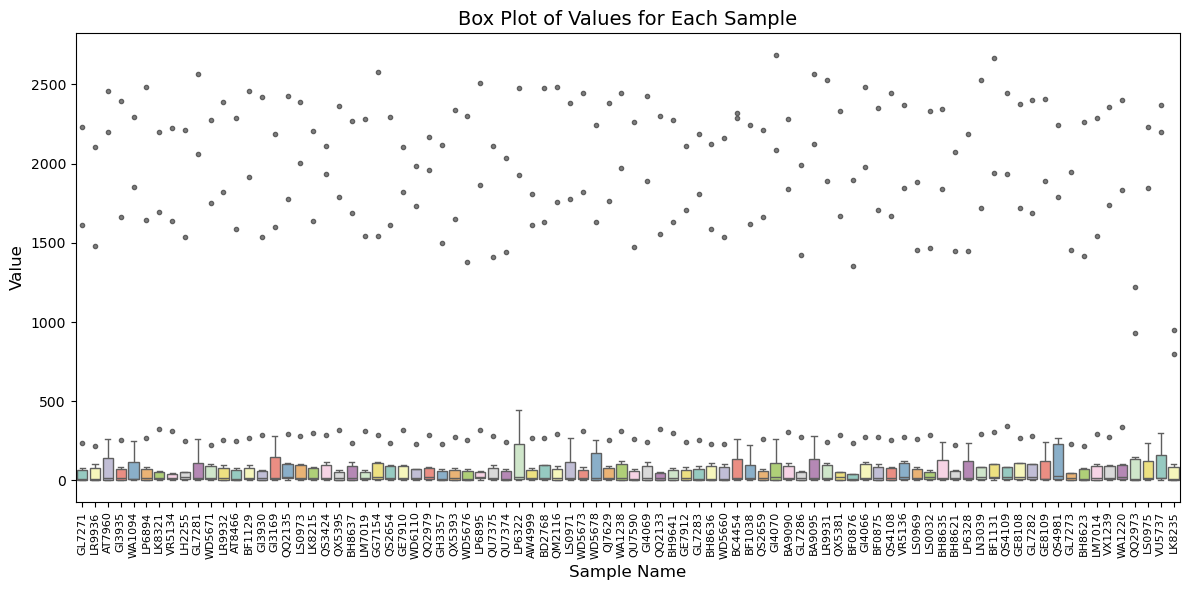

In [14]:
data_transposed = data.T

# Create the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=data_transposed, palette="Set3",flierprops=dict(marker='.', markerfacecolor='grey',linestyle='none'))
plt.title("Box Plot of Values for Each Sample", fontsize=14)
plt.xlabel("Sample Name", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.xticks(rotation=90,fontsize=8)  # Rotate sample names for better readability
plt.tight_layout() #Adjust the layout to prevent overlapping of labels.
plt.savefig(os.path.join(outputDir, "boxplot_lipidomics_samples.pdf"))
plt.show()

plt.close()

In [15]:
data_transposed.head()


,GL7271,LR9936,AT7960,GI3935,WA1094,LP6894,LK8321,VR5134,LH2255,GL7281,...,QS4981,GL7273,BH8623,LM7014,VX1239,WA1220,QQ2973,LS0975,VU5737,LK8235
CER,11.202778,9.905791,13.690628,14.477698,13.848749,16.799108,13.527708,17.418285,29.786294,13.47717,...,15.7459,17.141312,11.545732,15.022077,14.356478,24.177495,8.759078,14.0438,19.246269,4.428092
CE,1.527671,1.107148,3.716625,1.528347,1.146163,1.535373,5.700747,6.568787,2.00654,3.39768,...,7.979198,1.570829,2.423498,4.021367,1.319969,8.000851,3.548926,2.160003,13.539422,1.893427
DAG,20.104494,21.405943,30.146231,35.812048,24.005416,17.893678,22.823714,20.616167,20.77815,44.999747,...,232.095173,45.680563,50.861687,70.535614,94.627423,84.016751,119.401084,122.712553,139.426967,89.764983
DCER,1.881663,1.66522,2.318772,2.580021,2.573872,2.626726,2.317895,2.662495,3.912231,2.785339,...,3.017673,2.373818,2.1263,2.096196,2.129256,4.157721,1.621677,2.687671,3.14211,0.928337
HCER,80.539678,101.070828,183.308099,88.172331,144.073754,87.210527,60.33904,49.712126,54.040491,135.742572,...,128.757007,42.666041,81.347017,48.329299,70.821878,101.111931,48.474908,115.924654,165.267512,49.159522


## PCA

Note for **confidence ellipses** that represent the distribution of points for each group. To achieve this, you can use the matplotlib.patches.Ellipse class and calculate the ellipse parameters (center, width, height, and angle) based on the mean and covariance of the data points for each group.

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.patches import Ellipse
from scipy.stats import chi2
from pandas.api.types import CategoricalDtype  # For categorical type checking

def plot_pca_triangular(pc_df,variance_explained, hue="group", alpha_dot=0.8, figsize=(15, 15),save_path="pca_plot.pdf"):
    """
    Plot 2D combinations of the first four principal components in a triangular arrangement,
    with points colored by a specified grouping column, explained variance in axis labels,
    and ellipses summarizing each group.

    Parameters:
        pc_df (pd.DataFrame): DataFrame containing PC1, PC2, PC3, PC4, and a grouping column.
        hue (str): Column name in pc_df to use for coloring points (default: "group").
        figsize (tuple): Size of the figure (default: (15, 15)).

    Returns:
        None (displays the plot).
    """
    # Check if the hue column exists in pc_df
    if hue not in pc_df.columns:
        raise ValueError(f"Column '{hue}' not found in pc_df.")

    # Convert the hue column to categorical if it's not already
    if not isinstance(pc_df[hue].dtype, CategoricalDtype):
        pc_df[hue] = pc_df[hue].astype('category')

    # Create a colormap for the categories
    categories = pc_df[hue].cat.categories
    colors = plt.cm.viridis(np.linspace(0, 1, len(categories)))
    cmap = ListedColormap(colors)

    # Create a figure with subplots arranged in a triangular shape
    fig, axs = plt.subplots(3, 3, figsize=figsize)

    # Remove unused subplots
    axs[0, 1].axis('off')  # Top-center subplot
    axs[0, 2].axis('off')  # Top-right subplot
    axs[1, 2].axis('off')  # Middle-right subplot


    # Function to plot confidence ellipses
    def plot_ellipse(ax, group_data, color, alpha=0.2):
        """
        Plot a confidence ellipse for a group of data points.
        """
        if len(group_data) < 2:
            return  # Not enough points to compute covariance

        # Calculate mean and covariance
        mean = np.mean(group_data, axis=0)
        cov = np.cov(group_data, rowvar=False)

        # Calculate eigenvalues and eigenvectors of the covariance matrix
        eigenvalues, eigenvectors = np.linalg.eigh(cov)

        # Calculate the angle of the ellipse
        angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))

        # Calculate the width and height of the ellipse
        # Using chi-squared distribution for confidence level (e.g., 95%)
        confidence_level = 0.95
        scale = np.sqrt(chi2.ppf(confidence_level, 2))  # 2 degrees of freedom for 2D data
        width, height = 2 * scale * np.sqrt(eigenvalues)

        # Create and add the ellipse
        ellipse = Ellipse(mean, width, height, angle=angle, edgecolor=color, facecolor=color, alpha=alpha)
        ax.add_patch(ellipse)

    # Plot PC1 vs PC2
    scatter = axs[0, 0].scatter(pc_df['PC1'], pc_df['PC2'], c=pc_df[hue].cat.codes, cmap=cmap, alpha=alpha_dot)
    for i, category in enumerate(categories):
        group_data = pc_df[pc_df[hue] == category][['PC1', 'PC2']].values
        plot_ellipse(axs[0, 0], group_data, color=colors[i])
    axs[0, 0].set_title('PC1 vs PC2')
    axs[0, 0].set_xlabel(f"PC1 (Explained Variance: {100 * variance_explained[0]:.1f}%)")
    axs[0, 0].set_ylabel(f"PC2 (Explained Variance: {100 * variance_explained[1]:.1f}%)")
    axs[0, 0].grid(True)

    # Plot PC1 vs PC3
    axs[1, 0].scatter(pc_df['PC1'], pc_df['PC3'], c=pc_df[hue].cat.codes, cmap=cmap, alpha=alpha_dot)
    for i, category in enumerate(categories):
        group_data = pc_df[pc_df[hue] == category][['PC1', 'PC3']].values
        plot_ellipse(axs[1, 0], group_data, color=colors[i])
    axs[1, 0].set_title('PC1 vs PC3')
    axs[1, 0].set_xlabel(f"PC1 (Explained Variance: {100 * variance_explained[0]:.1f}%)")
    axs[1, 0].set_ylabel(f"PC3 (Explained Variance: {100 * variance_explained[2]:.1f}%)")
    axs[1, 0].grid(True)

    # Plot PC1 vs PC4
    axs[2, 0].scatter(pc_df['PC1'], pc_df['PC4'], c=pc_df[hue].cat.codes, cmap=cmap, alpha=alpha_dot)
    for i, category in enumerate(categories):
        group_data = pc_df[pc_df[hue] == category][['PC1', 'PC4']].values
        plot_ellipse(axs[2, 0], group_data, color=colors[i])
    axs[2, 0].set_title('PC1 vs PC4')
    axs[2, 0].set_xlabel(f"PC1 (Explained Variance: {100 * variance_explained[0]:.1f}%)")
    axs[2, 0].set_ylabel(f"PC4 (Explained Variance: {100 * variance_explained[3]:.1f}%)")
    axs[2, 0].grid(True)

    # Plot PC2 vs PC3
    axs[1, 1].scatter(pc_df['PC2'], pc_df['PC3'], c=pc_df[hue].cat.codes, cmap=cmap, alpha=alpha_dot)
    for i, category in enumerate(categories):
        group_data = pc_df[pc_df[hue] == category][['PC2', 'PC3']].values
        plot_ellipse(axs[1, 1], group_data, color=colors[i])
    axs[1, 1].set_title('PC2 vs PC3')
    axs[1, 1].set_xlabel(f"PC2 (Explained Variance: {100 * variance_explained[1]:.1f}%)")
    axs[1, 1].set_ylabel(f"PC3 (Explained Variance: {100 * variance_explained[2]:.1f}%)")
    axs[1, 1].grid(True)

    # Plot PC2 vs PC4
    axs[2, 1].scatter(pc_df['PC2'], pc_df['PC4'], c=pc_df[hue].cat.codes, cmap=cmap, alpha=alpha_dot)
    for i, category in enumerate(categories):
        group_data = pc_df[pc_df[hue] == category][['PC2', 'PC4']].values
        plot_ellipse(axs[2, 1], group_data, color=colors[i])
    axs[2, 1].set_title('PC2 vs PC4')
    axs[2, 1].set_xlabel(f"PC2 (Explained Variance: {100 * variance_explained[1]:.1f}%)")
    axs[2, 1].set_ylabel(f"PC4 (Explained Variance: {100 * variance_explained[3]:.1f}%)")
    axs[2, 1].grid(True)

    # Plot PC3 vs PC4
    axs[2, 2].scatter(pc_df['PC3'], pc_df['PC4'], c=pc_df[hue].cat.codes, cmap=cmap, alpha=alpha_dot)
    for i, category in enumerate(categories):
        group_data = pc_df[pc_df[hue] == category][['PC3', 'PC4']].values
        plot_ellipse(axs[2, 2], group_data, color=colors[i])
    axs[2, 2].set_title('PC3 vs PC4')
    axs[2, 2].set_xlabel(f"PC3 (Explained Variance: {100 * variance_explained[2]:.1f}%)")
    axs[2, 2].set_ylabel(f"PC4 (Explained Variance: {100 * variance_explained[3]:.1f}%)")
    axs[2, 2].grid(True)

    # Add a colorbar to the figure, positioned to the right of the subplots
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    cbar = fig.colorbar(scatter, cax=cbar_ax, ticks=range(len(categories)))
    cbar.set_ticklabels(categories)
    cbar.set_label(hue)

    # Adjust layout and display the figure
    #plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for the colorbar
    plt.subplots_adjust(right=0.9)
    if save_path:
        # Extract the file extension
        file_extension = os.path.splitext(save_path)[1].lower()
        supported_formats = ['.pdf', '.png', '.svg', '.jpg', '.jpeg', '.tiff']

        if file_extension in supported_formats:
            plt.savefig(os.path.join(outputDir,save_path), format=file_extension[1:], bbox_inches='tight')
            print(f"Plot saved as {save_path}")
        else:
            raise ValueError(f"Unsupported file format: {file_extension}. Supported formats: {supported_formats}")

    plt.show()


In [17]:
metadata

,CLIENT IDENTIFIER,AMOUNT EXTRACTED CLP,BOX NUMBER,CLIENT MATRIX,CLIENT SAMPLE ID,CLIENT SAMPLE NUMBER,GENOTYPE,GROUP ID,GROUP NAME,GROUP NUMBER,SAMPLE AMOUNT,SAMPLE AMOUNT UNITS,SAMPLE BOX LOCATION,SAMPLE DESCRIPTION,SAMPLE STATUS,TIMEPOINT
GL7271,4079063452,75,5500038776,Tissue,GL7271,1,APOE33,APOE33_6M_Reg,APOE3/3 6M-Reg,1,>0.1,g,A1,cortex,Reg,6M
LR9936,4079063700,75,5500038776,Tissue,LR9936,4,APOE33,APOE33_6M_Reg,APOE3/3 6M-Reg,1,>0.1,g,D1,cortex,Reg,6M
AT7960,4079063453,75,5500038776,Tissue,AT7960,7,APOE33,APOE33_9M_Reg,APOE3/3 9M-Reg,2,>0.1,g,A2,cortex,Reg,9M
GI3935,4079063701,75,5500038776,Tissue,GI3935,10,APOE33,APOE33_9M_Reg,APOE3/3 9M-Reg,2,>0.1,g,D2,cortex,Reg,9M
WA1094,4079063454,75,5500038776,Tissue,WA1094,13,APOE33,APOE33_9M_Irreg,APOE3/3 9M-Irreg,3,>0.1,g,A3,cortex,Irreg,9M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WA1220,4079062770,75,5500236975,Tissue,WA1220,75,APOE34,APOE34_9M_Irreg,APOE3/4 9M-Irreg,13,>0.1,g,E5,cortex,Irreg,9M
QQ2973,4088330445,75,5500236975,Tissue,QQ2973,78,APOE34,APOE34_15M_Irreg,APOE3/4 15M-Irreg,14,>0.1,g,C6,cortex,Irreg,15M
LS0975,4068148888,75,5500236975,Tissue,LS0975,81,APOE34,APOE34_15M_Irreg,APOE3/4 15M-Irreg,14,>0.1,g,F6,cortex,Irreg,15M
VU5737,4088330454,75,5500236975,Tissue,VU5737,82,APOE34,APOE34_15M_Acyc,APOE3/4 15M-Acyc,15,>0.1,g,A7,cortex,Acyc,15M


In [19]:
pca_df

,PARENT_SAMPLE_NAME,PC1,PC2,PC3,PC4
0,GL7271,-94.258334,-39.015722,-47.385411,-20.509293
1,LR9936,-271.927929,-49.065603,-45.761274,-43.031654
2,AT7960,481.402305,238.175953,-62.728419,-44.179155
3,GI3935,62.436629,-110.209218,-20.259866,-21.865326
4,WA1094,119.253071,95.134621,-56.749081,-38.982777
...,...,...,...,...,...
81,WA1220,194.213572,10.109955,24.808167,46.635878
82,QQ2973,-1297.633818,164.663211,110.875549,-28.602747
83,LS0975,64.547252,146.536479,92.526543,-27.252680
84,VU5737,417.136780,312.751463,56.543210,-1.861078


In [27]:
# Perform PCA
from sklearn.preprocessing import StandardScaler
# Step 1: Scale the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)  # Standardize the data (mean=0, std=1)

# Step 2: Perform PCA
pca = PCA(n_components=4)  # Adjust the number of components as needed
pca_results = pca.fit_transform(data_scaled)  # Fit PCA on the scaled data

# Create a DataFrame for the PCA results

pca_df = pd.DataFrame(pca_results, columns=["PC1", "PC2","PC3","PC4"], index=data.index)
# Reset the index of pc_df to make it a column
pca_df = pca_df.reset_index().rename(columns={'index': 'CLIENT SAMPLE ID'})

# Merge sample_df with pc_df_reset on 'PARENT_SAMPLE_NAME'
pca_df = pd.merge(pca_df, metadata)
# Add group information to the PCA results
# TIMEPOINT, GENOTYPE, GROUP_ID, GROUP_NAME, SAMPLE_STATUS


Plot saved as status_lipidAll.pdf


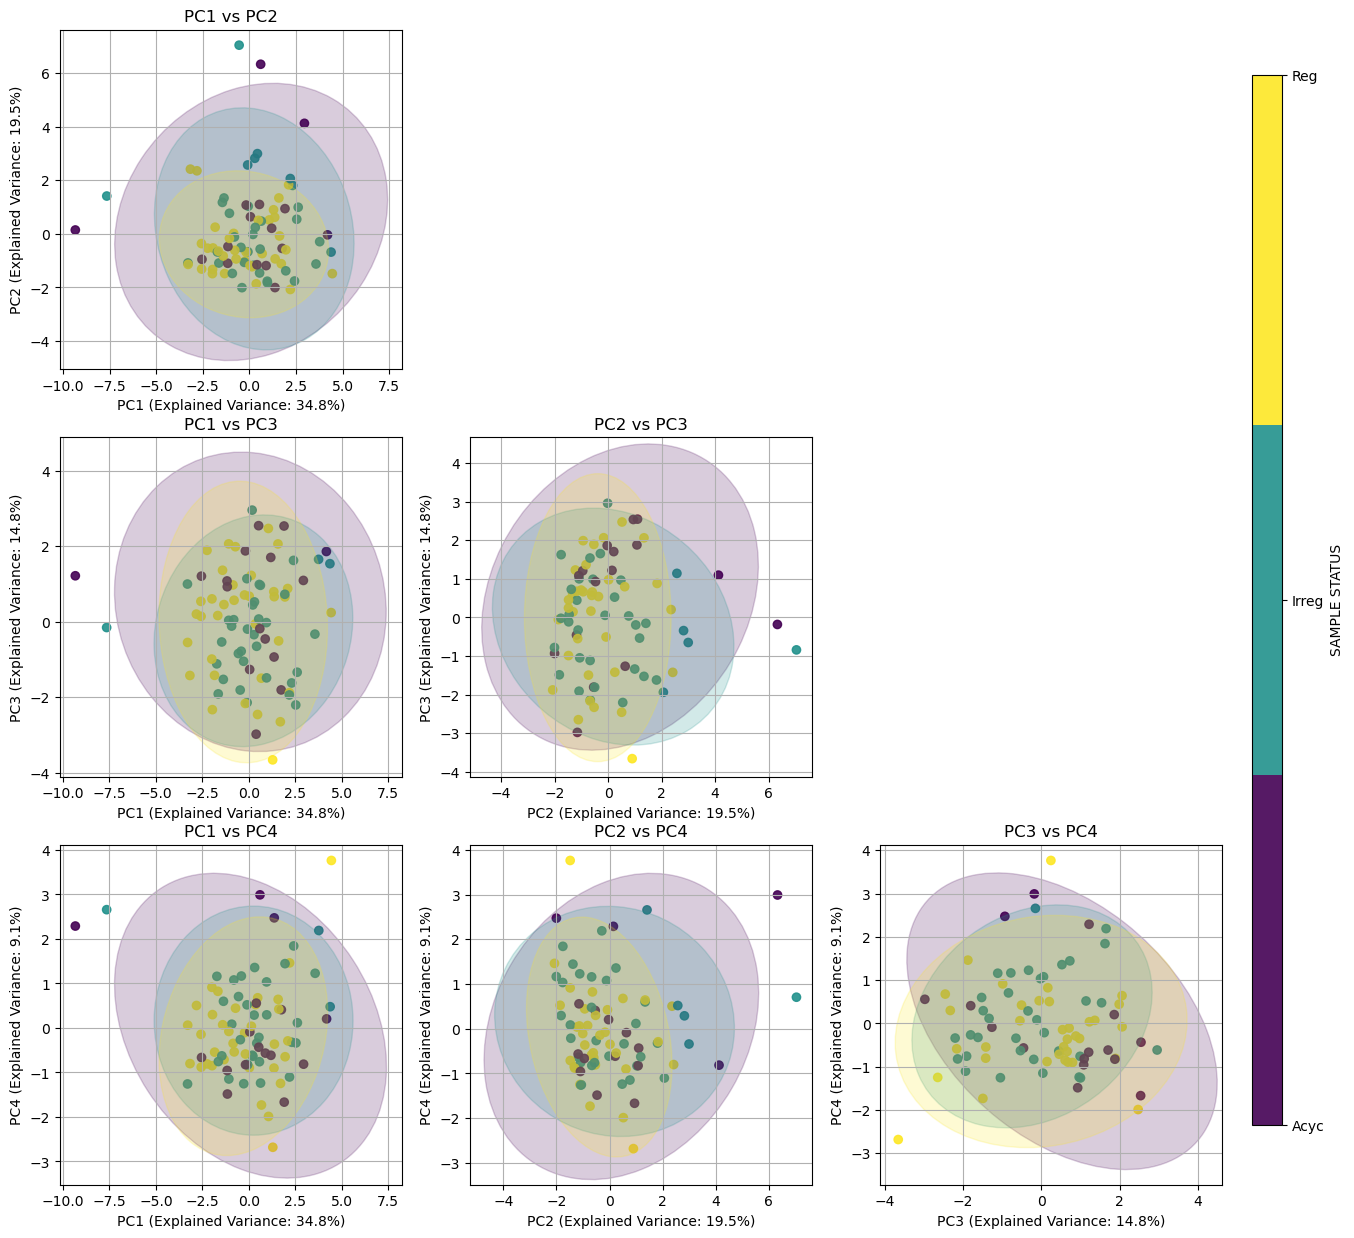

In [28]:
plot_pca_triangular(pca_df,pca.explained_variance_ratio_,hue="SAMPLE STATUS",alpha_dot=0.9,save_path="status_lipidAll.pdf")

In [23]:
metadata.columns

Index(['CLIENT IDENTIFIER', 'AMOUNT EXTRACTED CLP', 'BOX NUMBER',
       'CLIENT MATRIX', 'CLIENT SAMPLE ID', 'CLIENT SAMPLE NUMBER', 'GENOTYPE',
       'GROUP ID', 'GROUP NAME', 'GROUP NUMBER', 'SAMPLE AMOUNT',
       'SAMPLE AMOUNT UNITS', 'SAMPLE BOX LOCATION', 'SAMPLE DESCRIPTION',
       'SAMPLE STATUS', 'TIMEPOINT'],
      dtype='object')

Plot saved as TIMEPOINT_lipidAll.pdf


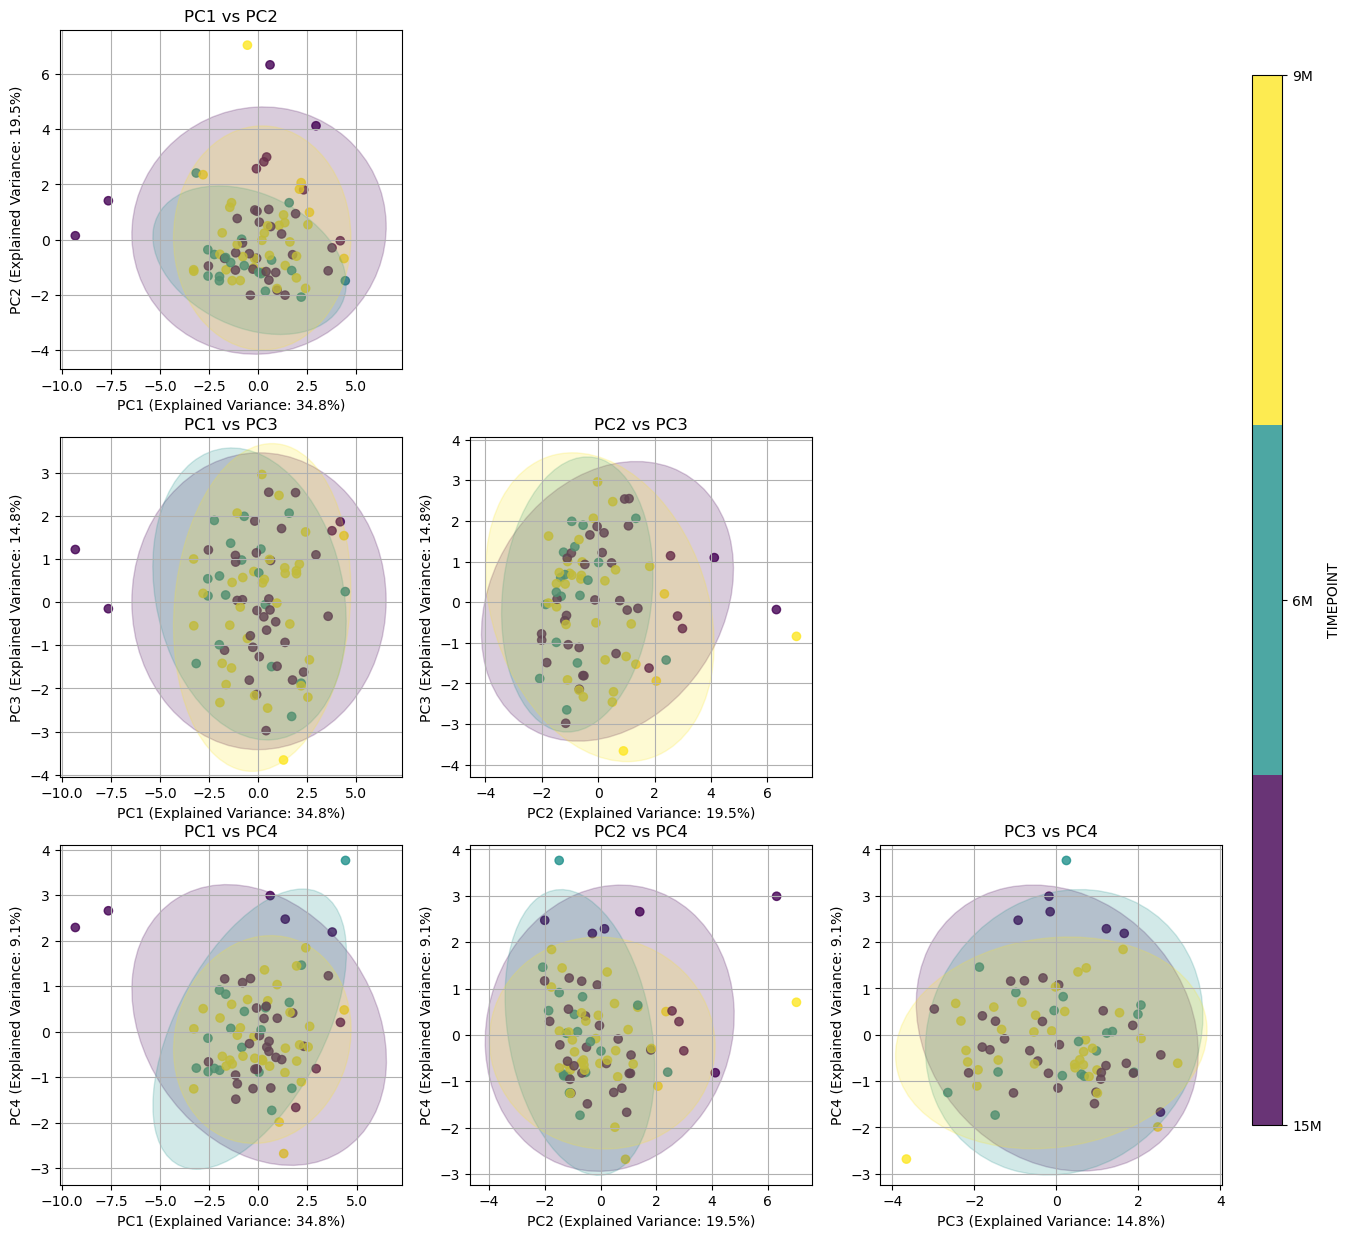

In [29]:
col_select = "TIMEPOINT"
plot_pca_triangular(pca_df,pca.explained_variance_ratio_,hue=col_select,save_path=col_select+"_lipidAll.pdf")

Plot saved as TIMEPOINT_lipidAll.pdf


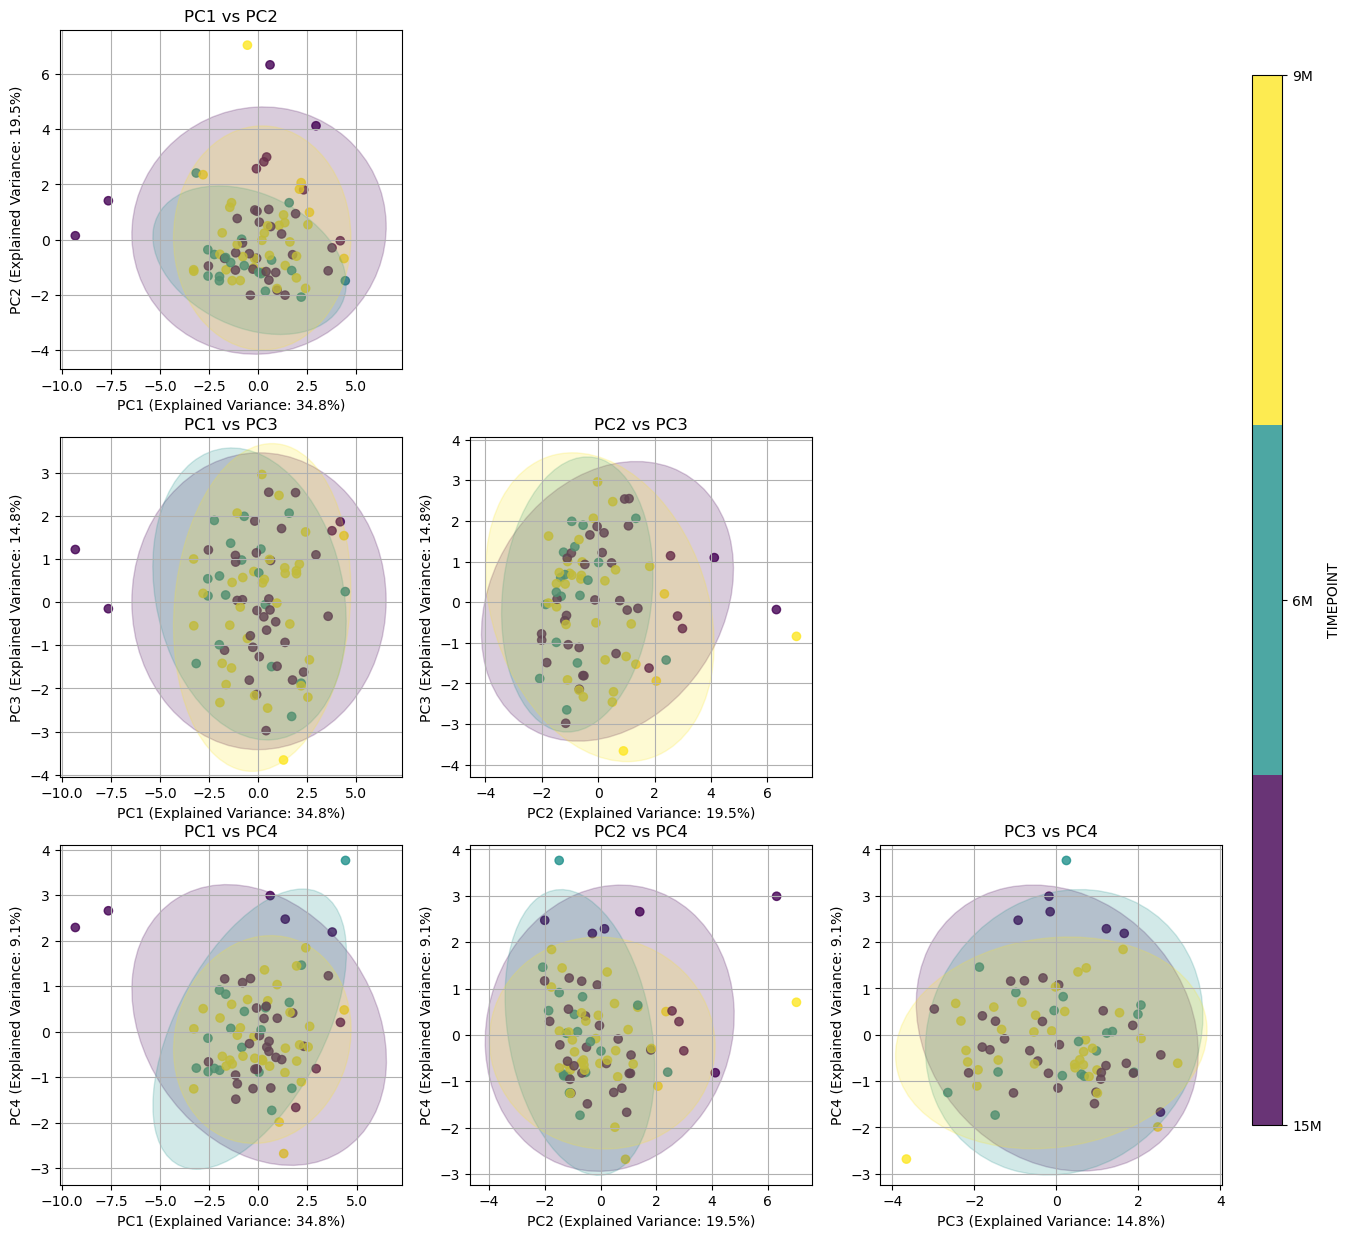

In [30]:
col_select = "TIMEPOINT"
plot_pca_triangular(pca_df,pca.explained_variance_ratio_,hue=col_select,save_path=col_select+"_lipidAll.pdf")

Plot saved as GENOTYPE_lipidAll.pdf


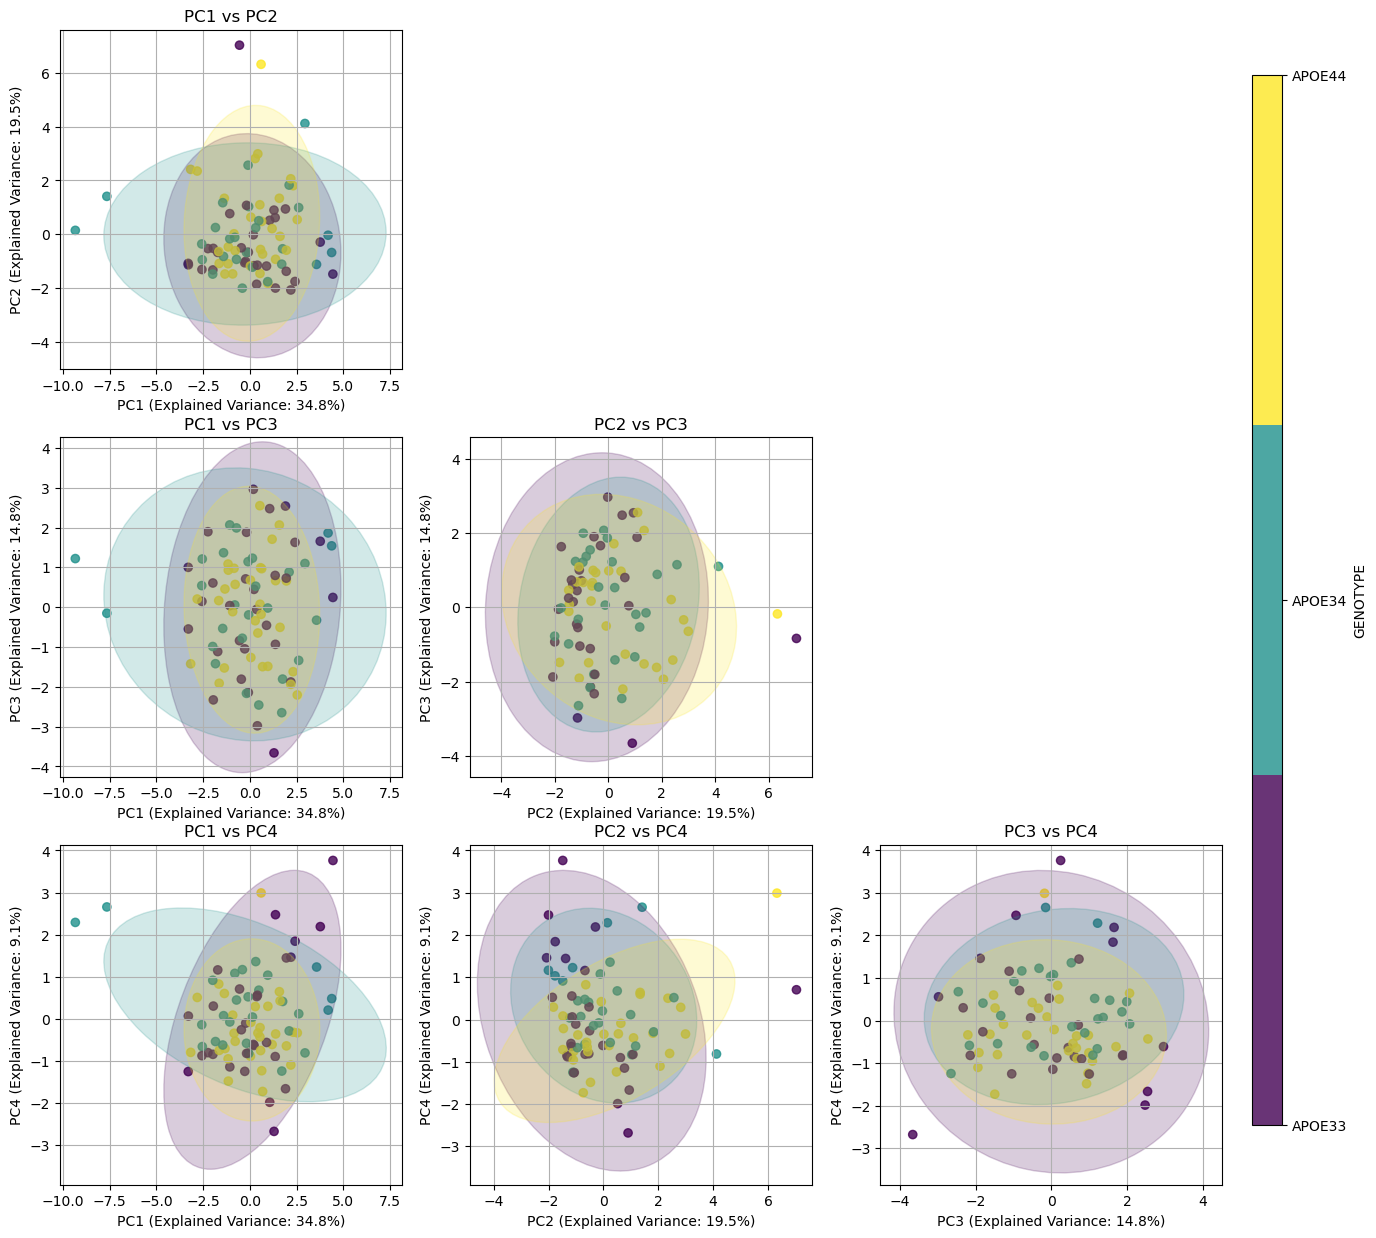

In [31]:
col_select = "GENOTYPE"
plot_pca_triangular(pca_df,pca.explained_variance_ratio_,hue=col_select,save_path=col_select+"_lipidAll.pdf")

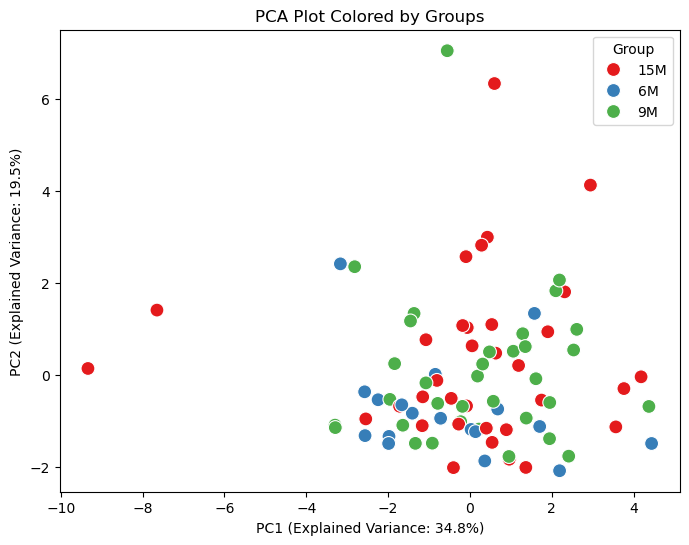

In [35]:
# Plot the PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x="PC1", y="PC2", hue="TIMEPOINT", data=pca_df, palette="Set1", s=100
)
plt.title("PCA Plot Colored by Groups")
plt.xlabel(f"PC1 (Explained Variance: {100*pca.explained_variance_ratio_[0]:.1f}%)")
plt.ylabel(f"PC2 (Explained Variance: {100*pca.explained_variance_ratio_[1]:.1f}%)")
plt.legend(title="Group")
plt.show()

# Read all lipidomics

In [ ]:

# Load the Excel file
sheet_name = "Lipid Class Concentrations"  # Replace with the name of the sheet you want to read

# Read the Excel file
df = pd.read_excel(filepath, sheet_name=sheet_name, header=None)


# Extract metadata (rows 6 to 21, excluding the first 2 columns)
metadata = df.iloc[5:21, 3:].copy().T  # Transpose the metadata
metadata.columns = df.iloc[5:21, 2].tolist()  # Set the header row (row 5) as column names
metadata.index = df.iloc[9, 3:].tolist()  # Set the sample names as the index
#metadata.index.name = "Sample Name"  # Name the index

# Extract chemical names and classes (rows 23 to 36, first 2 columns)
chemical_info = df.iloc[22:36, 0:2].copy()
chemical_info.columns = df.iloc[21, :2].tolist() # Set column names
chemical_info.set_index("Name", inplace=True)  # Set chemical names as the index

# Extract data (rows 23 to 36, excluding the first 3 columns)
data = df.iloc[22:36, 3:].copy().T  # Transpose the data
data.columns = df.iloc[22:36, 1].tolist()  # Set the chemical names as column names
data.index = df.iloc[9, 3:].tolist()  # Set the sample names as the index
#data.index.name = "Sample Name"  # Name the index

# Display the extracted data
print("Metadata:")
print(metadata)
print("\nChemical Information:")
print(chemical_info)
print("\nData:")
print(data)